In [40]:
import xgboost as xgb
import pandas as pd
import numpy as np

In [65]:
#loading data from csv
training_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")
gender_submission = pd.read_csv('./datasets/gender_submission.csv')

In [74]:
test_data = pd.merge(test_data, gender_submission, how='inner', on=['PassengerId', 'PassengerId'])

In [75]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [62]:
#for feature in training_data.columns: # Loop through all columns in the dataframe
#    if training_data[feature].dtype == 'object': # Only apply for columns with categorical strings
#        training_data[feature] = pd.Categorical(training_data[feature]).codes # Replace strings with an integer

In [76]:
training_y = training_data.pop('Survived')
testing_y = test_data.pop('Survived')

In [78]:
training_data.head()
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [83]:
for feature in training_data.columns: # Loop through all columns in the dataframe
    if training_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        training_data[feature] = pd.Categorical(training_data[feature]).codes # Replace strings with an integer

for feature in test_data.columns: # Loop through all columns in the dataframe
    if test_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        test_data[feature] = pd.Categorical(test_data[feature]).codes # Replace strings with an integer
        

In [86]:
xgdmat = xgb.DMatrix(training_data, training_y) # Create our DMatrix to make XGBoost more efficient


In [56]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

In [87]:
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /work

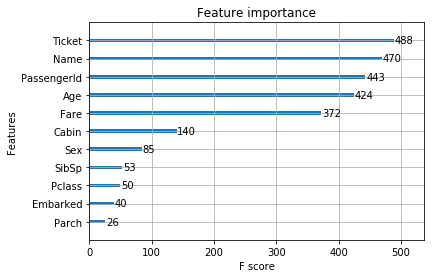

In [88]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_gb)


In [90]:
print("Validating...")
check = final_gb.predict(xgb.DMatrix(test_data), ntree_limit=final_gb.best_iteration+1)


Validating...


In [93]:
from sklearn.metrics import average_precision_score

#area under the precision-recall curve
score = average_precision_score(testing_y.values, check)
print('area under the precision-recall curve: {:.6f}'.format(score))

area under the precision-recall curve: 0.810385


precision score: 0.728571
recall score: 0.671053
('Importance array: ', [('Ticket', 488), ('Name', 470), ('PassengerId', 443), ('Age', 424), ('Fare', 372), ('Cabin', 140), ('Sex', 85), ('SibSp', 53), ('Pclass', 50), ('Embarked', 40), ('Parch', 26)])
Predict test set... 
area under the precision-recall curve test set: 0.810385


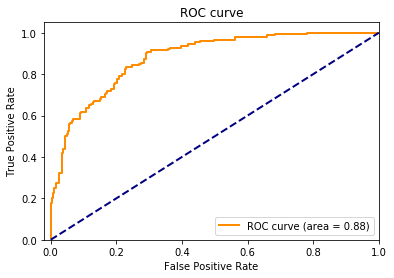

In [101]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
check2=check.round()
score = precision_score(testing_y.values, check2)
print('precision score: {:.6f}'.format(score))

score = recall_score(testing_y.values, check2)
print('recall score: {:.6f}'.format(score))
    
imp = get_importance(final_gb, test_data.columns)
print('Importance array: ', imp)

print("Predict test set... ")
test_prediction = final_gb.predict(xgb.DMatrix(test_data), ntree_limit=final_gb.best_iteration+1)
score = average_precision_score(testing_y.values, test_prediction)

print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
############################################ ROC Curve
    

 
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(testing_y.values, check)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
##################################################